(week12:goes_earthcare)=
# goes-earthcare overlay

## Introduction

This notebook 

- reads in the netcdf file container the Earthcare case you saved in {ref}`week12:goes_earthcare`
- finds the closest GOES 16 or GOES 18 image and extracts the cloud top height and the channel 14 (11 micron) brightness temperature
- crops the GOES image to the region of the Earthcare radar groundtrack
- plots the groundtrack on top of the GOES heights

This sets up the second problem in {ref}`week12:assign8`

## Installation

- fetch and rebase to pick up the week12 folder with this ipynb file
- `pip install -r requirements.txt`  to install the newest version of the `a301_extras` library

## open the earthcare radar file

In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import pyproj
from matplotlib import pyplot as plt
import datetime
import pytz
import pandas as pd
from pyproj import CRS, Transformer
import affine
from a301_extras.sat_lib import make_new_rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature

running __init__.py


In [2]:
data_dir = Path().home() / 'repos/a301/satdata/earthcare'
radar_filepath = list(data_dir.glob("**/*.nc"))[0]
radar_ds = xr.open_dataset(radar_filepath)
radar_ds

<xarray.Dataset> Size: 21MB
Dimensions:     (height: 218, distance: 8021)
Coordinates:
  * height      (height) float64 2kB 2.019e+04 2.009e+04 ... -1.494e+03
  * distance    (distance) float64 64kB 0.0 0.5027 1.006 ... 4.172e+03 4.172e+03
Data variables:
    dbZ         (height, distance) float32 7MB ...
    velocity    (height, distance) float32 7MB ...
    binHeights  (height, distance) float32 7MB ...
    longitude   (distance) float64 64kB ...
    latitude    (distance) float64 64kB ...
    time        (distance) datetime64[ns] 64kB ...
Attributes:
    history:   written by ec_to_xarray on 2025-03-29 09:50:41.584666
    timezone:  UTC
    casenum:   case4

### get the time and bounding box corners

In [3]:
midpoint = int(len(radar_ds['time'])/2.)
midtime = radar_ds['time'][midpoint].data

#datetime.datetime(midtime)
timestamp = pd.to_datetime(midtime)
timestamp

Timestamp('2024-12-13 22:50:35.447906')

In [4]:
lats = radar_ds['latitude']
lons = radar_ds['longitude']
ymin, ymax = np.min(lats.data),np.max(lats.data)
xmin, xmax = np.min(lons.data),np.max(lons.data)
print(f"{(xmin,ymin,xmax,ymax)=}")

(xmin,ymin,xmax,ymax)=(np.float64(-131.09466120436687), np.float64(22.36695226805222), np.float64(-119.84172089591294), np.float64(59.05850560602393))


### overwrite bounding box

We want a wider bounding box, since radar groundtrack is almost due north-south.
GOES west probably has a better view, so use GOES 18

In [5]:
xmin = -145
xmax = -85.
ymax = 70

## Find the nearest GOES image

### Function get_goes

In [6]:
from goes2go import goes_nearesttime
save_dir = Path.home() / "repos/a301/satdata/earthcare"
def get_goes(timestamp, satellite="goes16", product="ABI-L2-MCMIP",domain="C",
             download=True, save_dir=None):
    g = goes_nearesttime(
        timestamp, satellite=satellite,product=product, domain=domain, 
          return_as="xarray", save_dir = save_dir, download = download, overwrite = False
    )
    the_path = g.path[0]
    return the_path

/Users/phil/mini310/envs/a301/lib/python3.13/site-packages/goes2go/data.py:673: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),
/Users/phil/mini310/envs/a301/lib/python3.13/site-packages/goes2go/NEW.py:185: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),


## Get the cloudtop height

This variable is in the `ABI-L2-ACHAC` product, at 10 km resolution.  It is available every 60 minutes. The
full description is [here](https://www.star.nesdis.noaa.gov/goesr/docs/ATBD/Cloud_Height.pdf)

In [7]:
download_dict = dict(satellite="goes18",product = "ABI-L2-ACHAC",save_dir=save_dir)

In [8]:
writeit = False
if writeit:
    the_path = get_goes(timestamp,**download_dict)
else:
    the_path = ('noaa-goes18/ABI-L2-ACHAC/2024/348/22/OR_ABI-L2-ACHAC-M6_G18_s20243482251177'
                '_e20243482253550_c20243482256172.nc'
               )
full_path = save_dir / the_path

In [9]:
the_path

'noaa-goes18/ABI-L2-ACHAC/2024/348/22/OR_ABI-L2-ACHAC-M6_G18_s20243482251177_e20243482253550_c20243482256172.nc'

In [10]:
goes_ct = xr.open_dataset(full_path,mode = 'r',mask_and_scale = True)
type(goes_ct)

xarray.core.dataset.Dataset

## calculate the projection coordinates

The x and y coordinates for the Dataset `goes_ct` are in radians.  The function `parse_cf` (where `CF` stands
for `climate and forecast`) extracts a dataset variable as a DataArray and converts those x and y values to meters in the geostationary CRS by multiplying by the height of the satellite. It also sets the `grid_mapping` attribute
to `goes_imager_projection` which allows goes2go to produce the geostationary CRS using `cloud_ct.metpy.pyproj_crs` or `cloud_ct.metpy.cartopy_crs`. The CF conventions
are documented [here](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/cf-conventions.html#_geostationary_projection) ).

In [11]:
cloud_top = goes_ct.metpy.parse_cf('HT')
type(cloud_top)

xarray.core.dataarray.DataArray

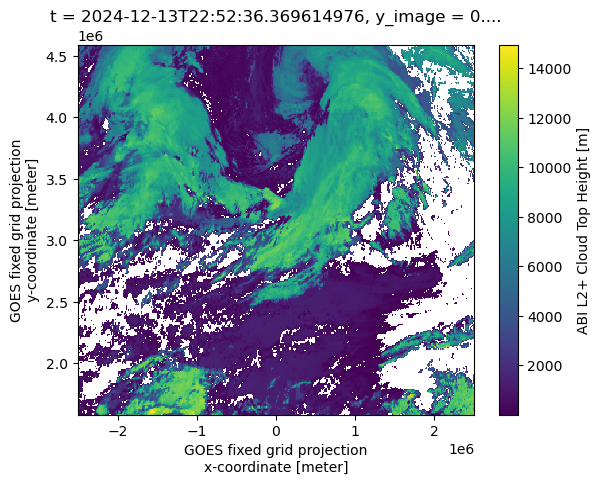

In [12]:
cloud_top.plot.imshow()

## Get the 11 micron thermal band

This is [channel 14](https://www.noaa.gov/jetstream/goes_east) in the
moisture and cloud product.  The brightness temperatures will have 2 km resolution,
but no atmospheric correction

In [13]:
download_dict = dict(satellite="goes18",
                     product = "ABI-L2-MCMIPC",save_dir=save_dir)

In [14]:
writeit = False
if writeit:
    the_path = get_goes(timestamp,**download_dict)
else:
    the_path = ('noaa-goes18/ABI-L2-MCMIPC/2024/348/22/OR_ABI-L2-MCMIPC-M6_G18_s20243482251177'
                '_e20243482253562_c20243482254081.nc'
               )
full_path = save_dir / the_path
the_path

'noaa-goes18/ABI-L2-MCMIPC/2024/348/22/OR_ABI-L2-MCMIPC-M6_G18_s20243482251177_e20243482253562_c20243482254081.nc'

In [15]:
goes_mc = xr.open_dataset(full_path,mode = 'r',mask_and_scale = True)
chan_14 = goes_mc.metpy.parse_cf('CMI_C14')

## Calculate the affine transforms

### Function get_affine

In [16]:
def get_affine(goes_da):
    resolutionx = np.mean(np.diff(goes_da.x))
    resolutiony = np.mean(np.diff(goes_da.y))
    ul_x = goes_da.x[0].data
    ul_y = goes_da.y[0].data
    goes_transform = affine.Affine(resolutionx, 0.0, ul_x, 0.0, resolutiony, ul_y)
    return goes_transform
    

In [17]:
cloud_top_affine = get_affine(cloud_top)
chan_14_affine = get_affine(chan_14)
chan_14_affine, cloud_top_affine

(Affine(np.float64(2004.017317102528), 0.0, np.float64(-2504019.637719609),
        0.0, np.float64(-2004.017295251391), np.float64(4588197.756226748)),
 Affine(np.float64(10020.086997746615), 0.0, np.float64(-2500011.439311132),
        0.0, np.float64(-10020.086272212475), np.float64(4584189.291191623)))

## convert  cloud_top  to a rioxarray

Use make_new_rioxarray introduced in {ref}`week8:goes_landsat_rio`

```python
def make_new_rioxarray(
    rawdata: np.ndarray,
    coords: dict,
    dims: tuple,
    crs: pyproj.CRS,
    transform: affine.Affine,
    attrs: dict | None = None,
    missing: float | None = None,
    name: str | None = "name_here") -> xr.DataArray:
    """
    create a new rioxarray from an ndarray plus components

    Parameters
    ----------

    rawdata: numpy array
    crs: pyproj crs for scene
    coords: xarray coordinate dict
    dims: x and y dimension names from coords
    transform: scene affine transform
    attrs: optional attribute dictionary
    missing: optional missing value
    name: optional variable name, defaults to "name_here"

    Returns
    -------

    rio_da: a new rioxarray
    """
```

### Set cloud top height attributes

In [18]:
attribute_names=['long_name','standard_name','units','grid_mapping']
attributes ={name:item for name,item in cloud_top.attrs.items()
             if name in attribute_names}
attributes['history'] = f"written by goes_earthcare.ipynb on {datetime.datetime.now()}"
attributes['start'] = goes_ct.attrs['time_coverage_start']
attributes['end'] = goes_ct.attrs['time_coverage_end']
attributes['dataset'] = goes_ct.attrs['dataset_name']
attributes['title'] = 'cloud layer height'
attributes

{'long_name': 'ABI L2+ Cloud Top Height',
 'standard_name': 'geopotential_height_at_cloud_top',
 'units': 'm',
 'grid_mapping': 'goes_imager_projection',
 'history': 'written by goes_earthcare.ipynb on 2025-03-30 21:30:34.580030',
 'start': '2024-12-13T22:51:17.7Z',
 'end': '2024-12-13T22:53:55.0Z',
 'dataset': 'OR_ABI-L2-ACHAC-M6_G18_s20243482251177_e20243482253550_c20243482256172.nc',
 'title': 'cloud layer height'}

In [19]:
the_dims = ('y','x')
goes_crs = cloud_top.metpy.pyproj_crs
coords_cloud_top = dict(x=cloud_top.x,y=cloud_top.y)
cloud_top_da = make_new_rioxarray(cloud_top,
                                  coords_cloud_top,
                                  the_dims,
                                  goes_crs,
                                  cloud_top_affine,
                                  attrs = attributes,
                                  missing=np.float32(np.nan),
                                  name = 'ht')
                                                                   

In [20]:
attribute_names=['long_name','standard_name','units','grid_mapping']
attributes ={name:item for name,item in chan_14.attrs.items()
             if name in attribute_names}
attributes['history'] = f"written by goes_earthcare.ipynb on {datetime.datetime.now()}"
attributes['start'] = goes_mc.attrs['time_coverage_start']
attributes['end'] = goes_mc.attrs['time_coverage_end']
attributes['dataset'] = goes_mc.attrs['dataset_name']
attributes['title'] = 'chan_14'
attributes

{'long_name': 'ABI Cloud and Moisture Imagery brightness temperature at top of atmosphere',
 'standard_name': 'toa_brightness_temperature',
 'units': 'K',
 'grid_mapping': 'goes_imager_projection',
 'history': 'written by goes_earthcare.ipynb on 2025-03-30 21:30:34.760017',
 'start': '2024-12-13T22:51:17.7Z',
 'end': '2024-12-13T22:53:56.2Z',
 'dataset': 'OR_ABI-L2-MCMIPC-M6_G18_s20243482251177_e20243482253562_c20243482254081.nc',
 'title': 'chan_14'}

## convert chan_14 to a rioxarray

### set chan_14 attributes

In [21]:
the_dims = ('y','x')
goes_crs = cloud_top.metpy.pyproj_crs
coords_chan_14 = dict(x=chan_14.x,y=chan_14.y)
chan_14_da = make_new_rioxarray(chan_14,
                                  coords_chan_14,
                                  the_dims,
                                  goes_crs,
                                  chan_14_affine,
                                  attrs = attributes,
                                  missing=np.float32(np.nan),
                                  name = 'chan_14')
                                  

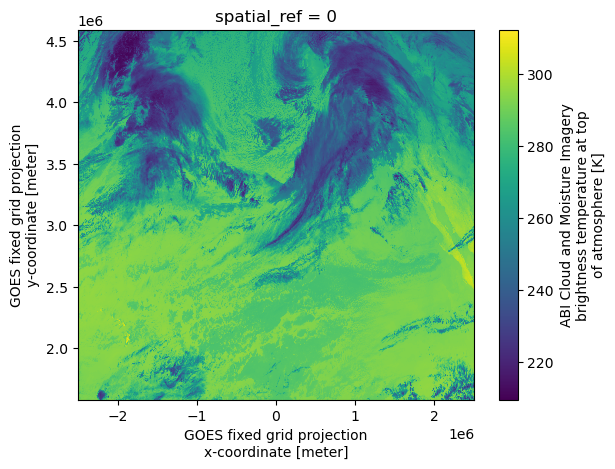

In [22]:
chan_14_da.plot.imshow()

## crop the images

We want to crop the images to the radar track.  To do that, we first need to get
the bounding box in geostationary coordinates, so we can use the `rio.clip_box` function.
We did this in week 8 in {ref}`week8:goes_clip_bounds`

In [23]:
xmin,ymin,xmax,ymax

(-145, np.float64(22.36695226805222), -85.0, 70)

### Transform the bounds from lat/lon to geostationary crs

In [24]:
#
# transform bounds from lat,lon to goes crs
#
latlon_crs = pyproj.CRS.from_epsg(4326)
transform = Transformer.from_crs(latlon_crs, goes_crs,always_xy=True)
xmin_goes,ymin_goes = transform.transform(xmin,ymin)
xmax_goes,ymax_goes = transform.transform(xmax,ymax)
print(f"{(xmax_goes - xmin_goes)=} m")
print(f"{(ymax_goes - ymin_goes)=} m")
bounds_goes = xmin_goes,ymin_goes,xmax_goes,ymax_goes

(xmax_goes - xmin_goes)=2302088.351741597 m
(ymax_goes - ymin_goes)=2825116.143064025 m


### Crop using clip_box

In [25]:
#
# now crop to these bounds using clip_box
#
clipped_cloud_top=cloud_top_da.rio.clip_box(*bounds_goes)
clipped_chan_14 = chan_14_da.rio.clip_box(*bounds_goes)

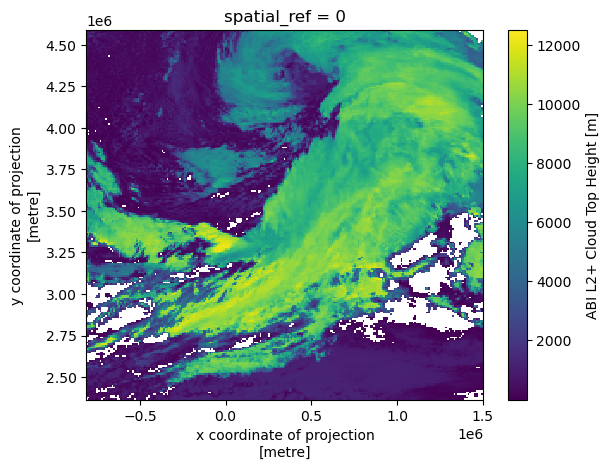

In [26]:
clipped_cloud_top.plot.imshow()

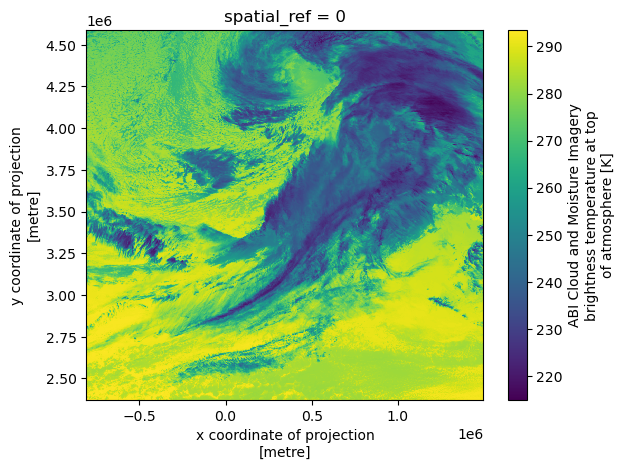

In [27]:
clipped_chan_14.plot.imshow()

## Make cartopy plots with radar ground track

Borrow code from {ref}`week8:cartopy_goes`

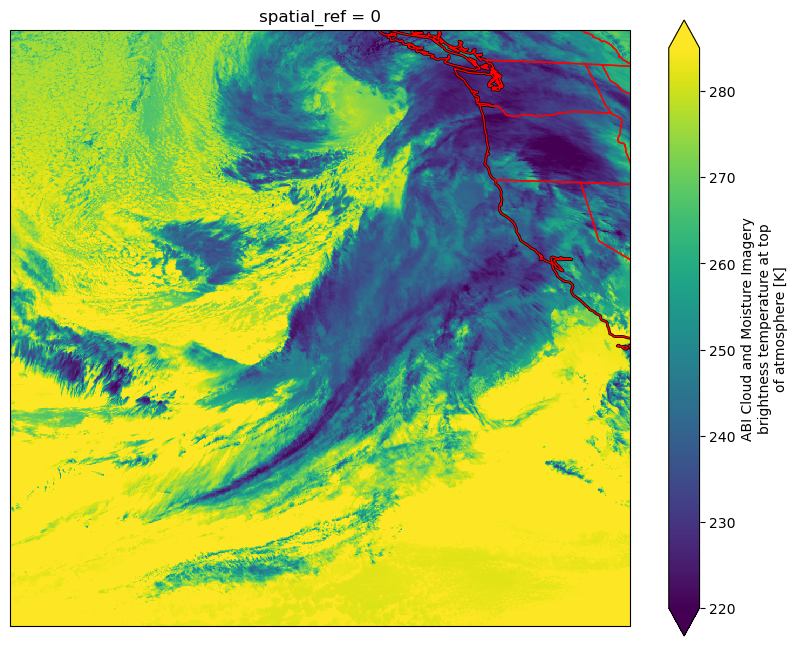

In [28]:
extent = (xmin_goes,xmax_goes,ymin_goes,ymax_goes)
cartopy_crs = cloud_top.metpy.cartopy_crs
fig,ax = plt.subplots(1,1,figsize=(10,8), subplot_kw={"projection":cartopy_crs})
clipped_chan_14.plot.imshow(
    ax = ax,
    origin="upper",
    extent= extent,
    transform=cartopy_crs,
    interpolation="nearest",
    vmin=220,
    vmax=285
);
ax.coastlines(resolution="50m", color="black", linewidth=2)
ax.add_feature(ccrs.cartopy.feature.STATES,edgecolor="red")

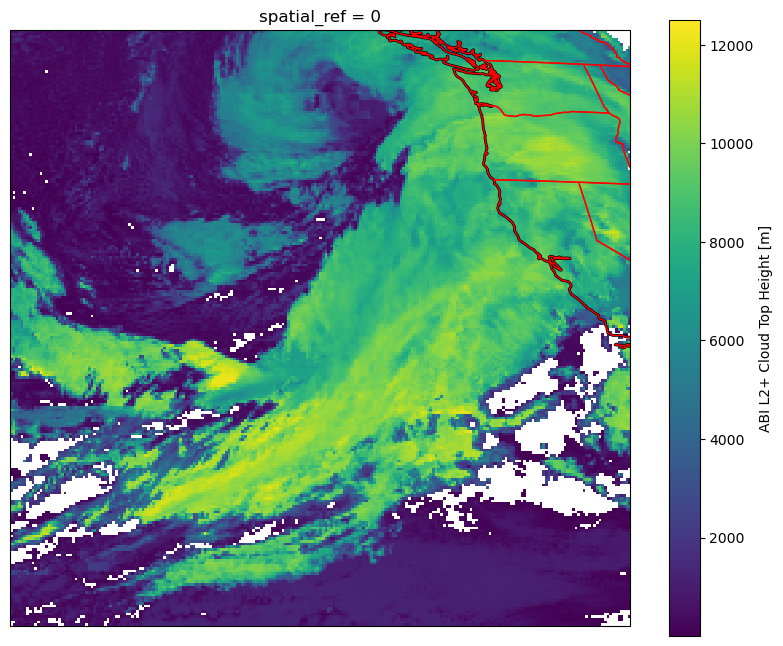

In [29]:
fig,ax = plt.subplots(1,1,figsize=(10,8), subplot_kw={"projection":cartopy_crs})
clipped_cloud_top.plot.imshow(
    ax = ax,
    origin="upper",
    extent= extent,
    transform=cartopy_crs,
    interpolation="nearest"
);
ax.coastlines(resolution="50m", color="black", linewidth=2)
ax.add_feature(ccrs.cartopy.feature.STATES,edgecolor="red");

## Add the groundtrack

In [30]:
goes_x, goes_y =  transform.transform(lons, lats)
hit = lats > 0

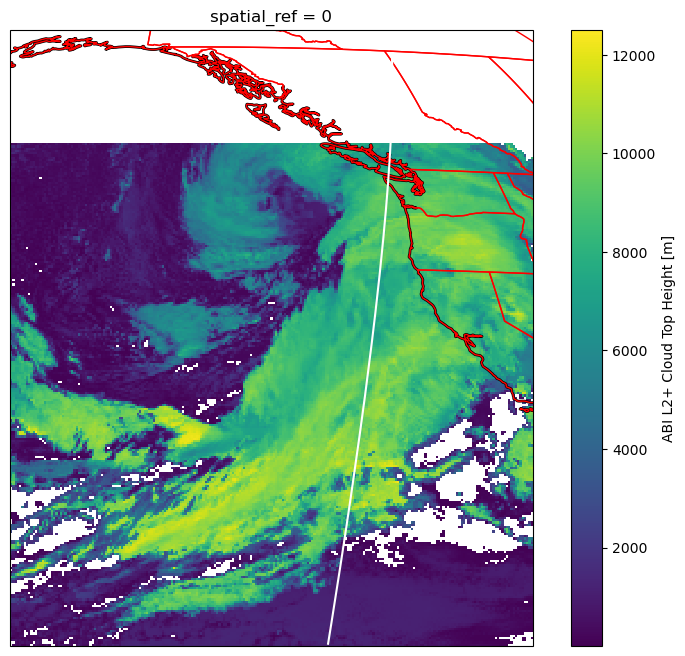

In [31]:
ax.plot(goes_x[hit],goes_y[hit],'w-')
display(fig)